In [57]:
import numpy as np
from collections import defaultdict
from pprint import pprint
import sys, os
import pickle as pkl
import matplotlib
import matplotlib.pyplot as plt

from os.path import expanduser
home = expanduser("~")
model_home = os.path.join(home, 'src/model/ca3_biophysical/')
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/utils'))
sys.path.append(os.path.join(home, 'src/model/ca3_biophysical/cells'))
sys.path.append(os.path.join(home, 'bin/nrnpython3/lib/python'))

from SetupConnections import Arena, WiringDiagram
from NeuronCircuit import Circuit
from analysis_utils import baks, restore_weights, saved_weight_change, spike_bins
from plot_utils import plot_spikes

font = {'family' : 'sans-serif',
        'sans-serif': 'Arial',
        'style': 'normal',
        'weight': 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [16]:

delay = 500.
dt = 0.1

params_path = os.path.join(model_home, 'params')
ar = Arena(os.path.join(params_path, 'arenaparams_lognormal.yaml'))
ar.generate_population_firing_rates()
ar.generate_cue_firing_rates('LEC', 1.0)
cued = True


In [17]:
ar.generate_spike_times('MF', dt=dt, delay=delay)
ar.generate_spike_times('MEC', dt=dt, delay=delay)
ar.generate_spike_times('LEC', dt=dt, delay=delay, cued=cued)
ar.generate_spike_times('Background', dt=dt, delay=delay)


[ 0  3  4 23 16  6 27 26 28 17 13 29 19  8 21 22 20  1 11  9 10 18 12 25
 14  5 24  2  7 15]


In [5]:
edge = 12.5
nlaps = 20
lp    = 1

arena_map  = np.arange(0, 200,step=0.1)
cued_positions  = np.linspace(edge, 200-edge, nlaps*lp)
random_cue_locs = np.arange(len(cued_positions))
np.random.shuffle(random_cue_locs)


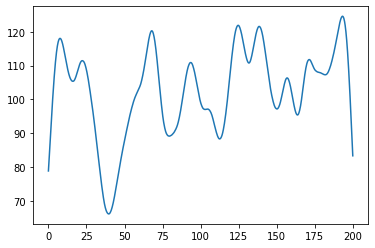

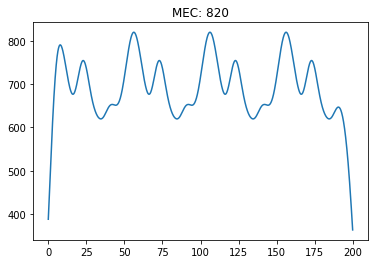

In [6]:
total_fr = None
for i in range(400):
    fr = ar.cell_information['MF']['cell info'][i]['firing rate']
    if i == 0:
        total_fr = np.copy(fr)
    else:
        total_fr += fr

plt.figure()
plt.plot(arena_map, total_fr)
plt.show()

   
total_fr = None
for i in range(200):
    fr = ar.cell_information['MEC']['cell info'][i]['firing rate']
    if i == 0:
        total_fr = np.copy(fr)
    else:
        total_fr += fr
        
plt.figure()
plt.plot(arena_map, total_fr)
plt.title('MEC: %i' % np.max(total_fr))
plt.show();





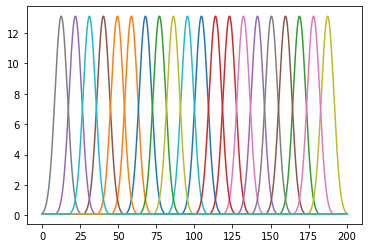

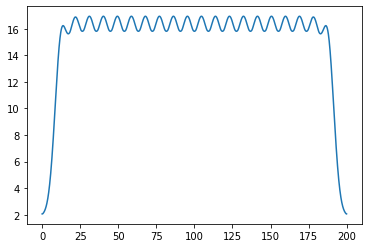

In [7]:
fr = ar.cell_information['LEC']['cell info'][0]['firing rate']


frs_all = []
for i in range(nlaps):
    random_position = cued_positions[random_cue_locs[i]]
    to_roll = int( ( 100. - random_position) / 0.1 )
    fr_rolled = np.roll(fr, to_roll)
    frs_all.append(fr_rolled)

frs_all = np.asarray(frs_all)

plt.figure()
for i in range(nlaps):
    plt.plot(arena_map, frs_all[i])
    
plt.figure()
plt.plot(arena_map,np.sum(frs_all, axis=0))

plt.show();

In [23]:
arena_size = ar.params['Arena']['arena size']
bin_size   = ar.params['Arena']['bin size']
mouse_speed = ar.params['Arena']['mouse speed']
nlaps       = ar.params['Arena']['lap information']['nlaps']

time_for_single_lap = arena_size / mouse_speed * 1000.
print(time_for_single_lap, nlaps)

6666.666666666667 15


In [8]:
place_information = {'place ids': [0], 'place fracs': [0.80]}

diagram = WiringDiagram(os.path.join(params_path, 'circuitparams_segs_stdp_ei_ie_mf_mec_lec.yaml'), 
                        place_information)
internal_kwargs = {}
internal_kwargs['place information'] = diagram.place_information
internal_kwargs['cue information'] = diagram.place_information
diagram.generate_internal_connectivity(**internal_kwargs)

place_ids = diagram.place_information[0]['place']
cue_ids = diagram.place_information[0]['not place']

external_kwargs = {}
external_kwargs['place information'] = diagram.place_information
external_kwargs['external place ids'] = [100, 101, 102]
external_kwargs['cue information'] = diagram.place_information
external_kwargs['external cue ids'] = [100, 101, 102]

diagram.generate_external_connectivity(ar.cell_information, **external_kwargs)

diagram.generate_septal_connectivity()




In [10]:
print(sorted(cue_ids))

[2, 3, 9, 12, 16, 22, 23, 24, 40, 41, 44, 47, 52, 55, 57, 58, 59, 67, 68, 79, 88, 90, 94, 106, 107, 132, 134, 137, 139, 141, 152, 158, 174, 182, 183, 185, 196, 198, 203, 214, 220, 223, 226, 234, 237, 243, 250, 254]


In [11]:
print(sorted(place_ids))

[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 224, 225, 227, 228, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259]


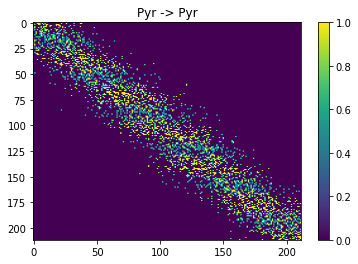

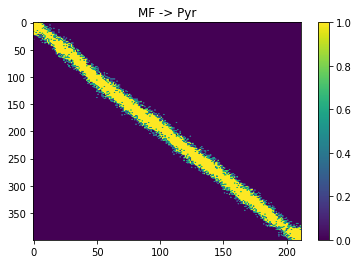

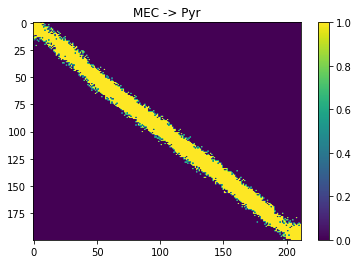

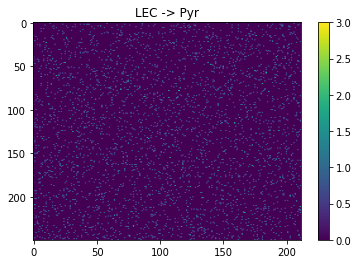

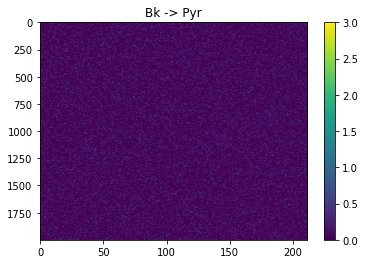

5005
7904
24720


In [12]:
plt.figure()
plt.title("Pyr -> Pyr")
plt.imshow(diagram.internal_adj_matrices[0][0][place_ids,:][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.title("MF -> Pyr")
plt.imshow(diagram.external_adj_matrices[100][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.title("MEC -> Pyr")
plt.imshow(diagram.external_adj_matrices[101][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.title("LEC -> Pyr")
plt.imshow(diagram.external_adj_matrices[102][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.title("Bk -> Pyr")

plt.imshow(diagram.external_adj_matrices[103][0][:,place_ids], aspect='auto')
plt.colorbar()
plt.show()

print(np.sum(diagram.internal_adj_matrices[0][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][1],axis=0).sum())


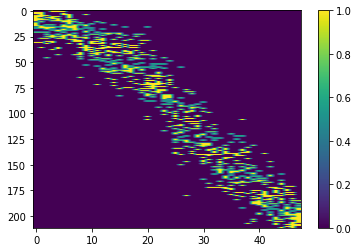

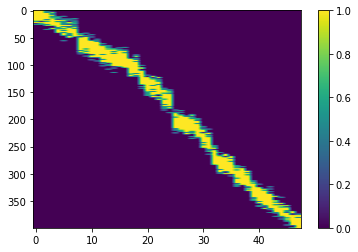

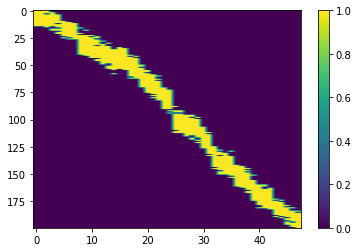

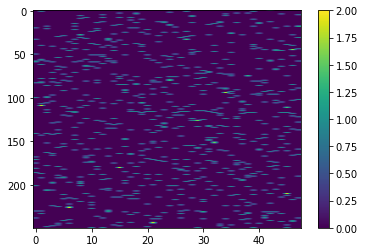

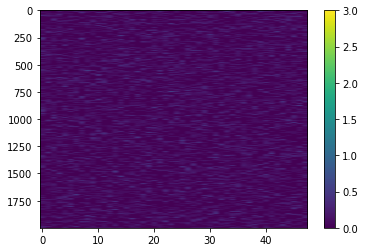

5005
7904
24720


In [13]:
plt.figure()
plt.imshow(diagram.internal_adj_matrices[0][0][place_ids,:][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(diagram.external_adj_matrices[100][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[101][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[102][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(diagram.external_adj_matrices[103][0][:,cue_ids], aspect='auto')
plt.colorbar()
plt.show()

print(np.sum(diagram.internal_adj_matrices[0][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][0],axis=0).sum())
print(np.sum(diagram.external_adj_matrices[100][1],axis=0).sum())


In [20]:
def get_spike_times(population2info_dict):
    spike_times = {}
    gids = np.sort(list(population2info_dict.keys()))
    for gid in gids:
        spike_times[gid] = population2info_dict[gid]['spike times']
    return spike_times

mf_spike_times  = get_spike_times(ar.cell_information['MF']['cell info'])
mec_spike_times = get_spike_times(ar.cell_information['MEC']['cell info'])
lec_spike_times = get_spike_times(ar.cell_information['LEC']['cell info'])
bk_spike_times  = get_spike_times(ar.cell_information['Background']['cell info'])

In [21]:
np.nonzero(diagram.external_adj_matrices[101][0][115])[0]

array([137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 161, 163])

z = 28
MF src ids: [14 18 27 28 29 31 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 61 62 63]


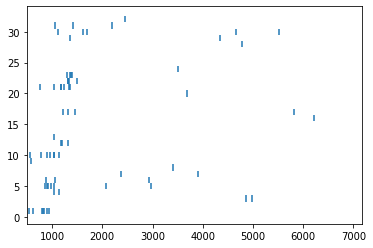

MEC src ids: [ 9 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 31 33]


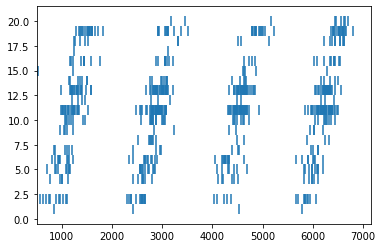

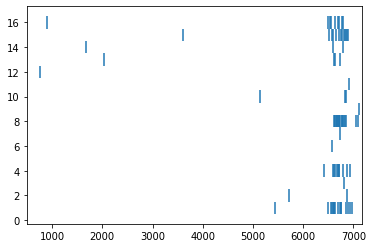

In [25]:
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500

place_cells = diagram.place_information[0]['place']

ctype_offset = diagram.external_information['MF']['ctype offset']
for z in place_cells[20:21]:

    print(f"z = {z}")
    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][:,z])[0]
    print(f"MF src ids: {src_ids}")
    i = 0
    for src_id in src_ids:
        
        src_gid = src_id # + ctype_offset
        if src_gid not in mf_spike_times:
            continue
            
        src_gid_spikes = mf_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    

ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][:,z])[0]
    print(f"MEC src ids: {src_ids}")
    i = 0
    for src_id in src_ids:
        src_gid = src_id # + ctype_offset
        if src_gid not in mec_spike_times:
            continue
        src_gid_spikes = mec_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id # + ctype_offset
        if src_gid not in lec_spike_times:
            continue
        src_gid_spikes = lec_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    


In [27]:
ext_spike_times = np.load("../data/ext_spikes_1023_grads_stdp_mf_input_lognormal-cue-ee-ei-nlaps-15.npz")
ext_spike_times = { int(k): v for k,v in ext_spike_times.items() }

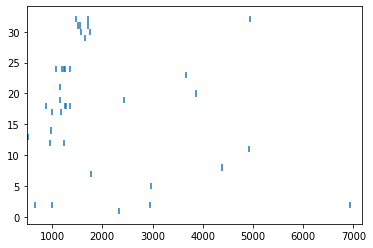

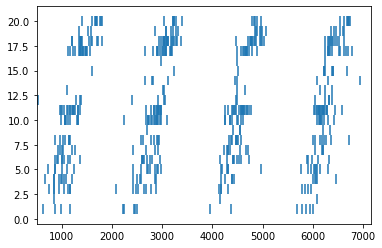

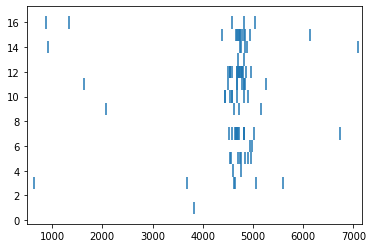

In [28]:
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500

place_cells = diagram.place_information[0]['place']

ctype_offset = diagram.external_information['MF']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
            
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    

ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in place_cells[20:21]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    


[2, 3, 9, 12, 16, 22, 23, 24, 40, 41, 44, 47, 52, 55, 57, 58, 59, 67, 68, 79, 88, 90, 94, 106, 107, 132, 134, 137, 139, 141, 152, 158, 174, 182, 183, 185, 196, 198, 203, 214, 220, 223, 226, 234, 237, 243, 250, 254]


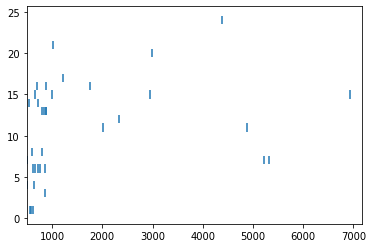

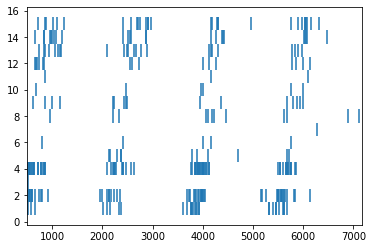

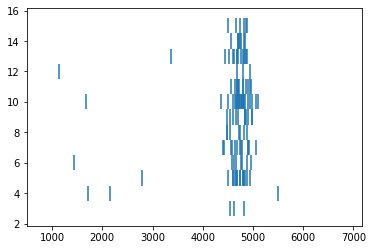

In [29]:
start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500

cue_cells = diagram.place_information[0]['not place']
print(cue_cells)

ctype_offset = diagram.external_information['MF']['ctype offset']

for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[100][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid in ext_spike_times:
            src_gid_spikes = ext_spike_times[src_gid]
            if len(src_gid_spikes) > 0:
                src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                       src_gid_spikes <= finish))]
                plt.vlines(list(src_spikes), i+0.5, i+1.5)
                i += 1
plt.xlim([start, finish])
plt.show();
    

ctype_offset = diagram.external_information['MEC']['ctype offset']
for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[101][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    
ctype_offset = diagram.external_information['LEC']['ctype offset']
for z in cue_cells[2:3]:

    plt.figure()
    src_ids = np.nonzero(diagram.external_adj_matrices[102][0][:,z])[0]
    i = 0
    for src_id in src_ids:
        src_gid = src_id + ctype_offset
        if src_gid not in ext_spike_times:
            continue
        src_gid_spikes = ext_spike_times[src_gid]
        if len(src_gid_spikes) > 0:
            src_spikes = src_gid_spikes[np.argwhere(np.logical_and(src_gid_spikes >= start,
                                                                   src_gid_spikes <= finish))]
            plt.vlines(list(src_spikes), i+0.5, i+1.5)
            i += 1
plt.xlim([start, finish])
plt.show();
    

    


In [63]:
exc_v_vecs = { int(k): v for k,v in np.load("../data/v_vecs_1104_grads_stdp_mf_input_lognormal-cue-ee-ei-nlaps-20.npz").items() }
dt = 0.025
t_end = exc_v_vecs[0].shape[0] * dt*4
t_vec = np.arange(0., t_end, dt*4)

In [64]:
t_end

133833.4

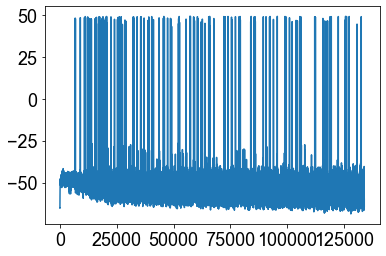

In [65]:
exc_v_vec_200 = exc_v_vecs[200]
plt.plot(t_vec, exc_v_vec_200)
plt.show();

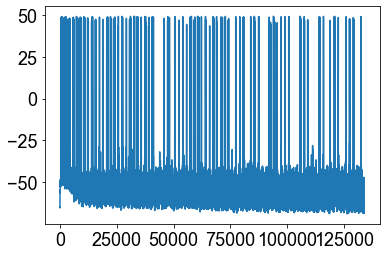

In [66]:
exc_v_vec_0 = exc_v_vecs[0]
plt.plot(t_vec, exc_v_vec_0)
plt.show();

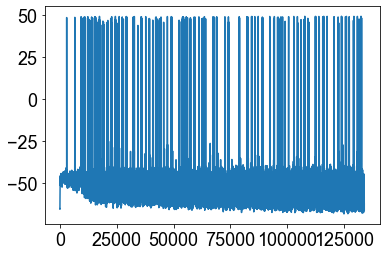

In [67]:
exc_v_vec_77 = exc_v_vecs[77]
plt.plot(t_vec, exc_v_vec_77)
plt.show();

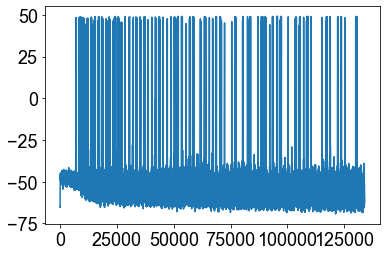

In [68]:
exc_v_vec_127 = exc_v_vecs[127]
plt.plot(t_vec, exc_v_vec_127)
plt.show();

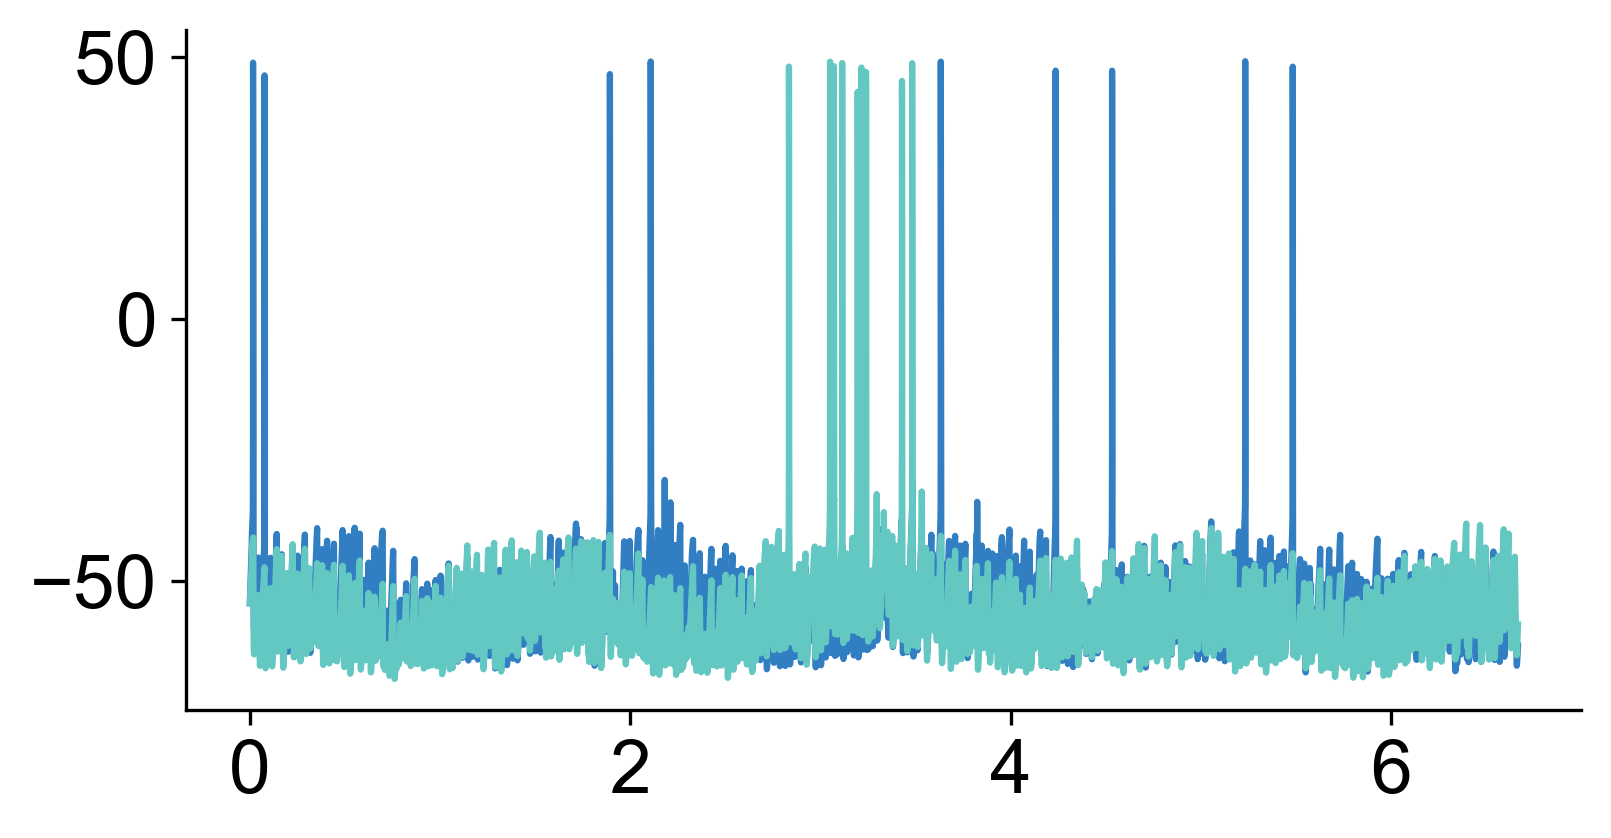

In [70]:
s = np.where(t_vec > time_for_single_lap*19+500)[0][0]
e = np.where(t_vec < time_for_single_lap*20+500)[0][-1]

# plt.figure()
# plt.plot(t_vec[s:e], list(exc_v_vecs[65])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[66])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[64])[s:e], color='k')
# plt.plot(t_vec[s:e], list(pvbc_v_vecs[0])[s:e], color='r')
# plt.show()

fig = plt.figure(figsize=(6,3), dpi=300)
ax  = fig.gca()
plt.plot( (t_vec[s:e]-t_vec[s])/1000., exc_v_vecs[77][s:e], color=(49/255., 126/255., 194/255.))
plt.plot( (t_vec[s:e]-t_vec[s])/1000., exc_v_vecs[127][s:e], color=(100/255., 200/255., 194/255.))
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show();

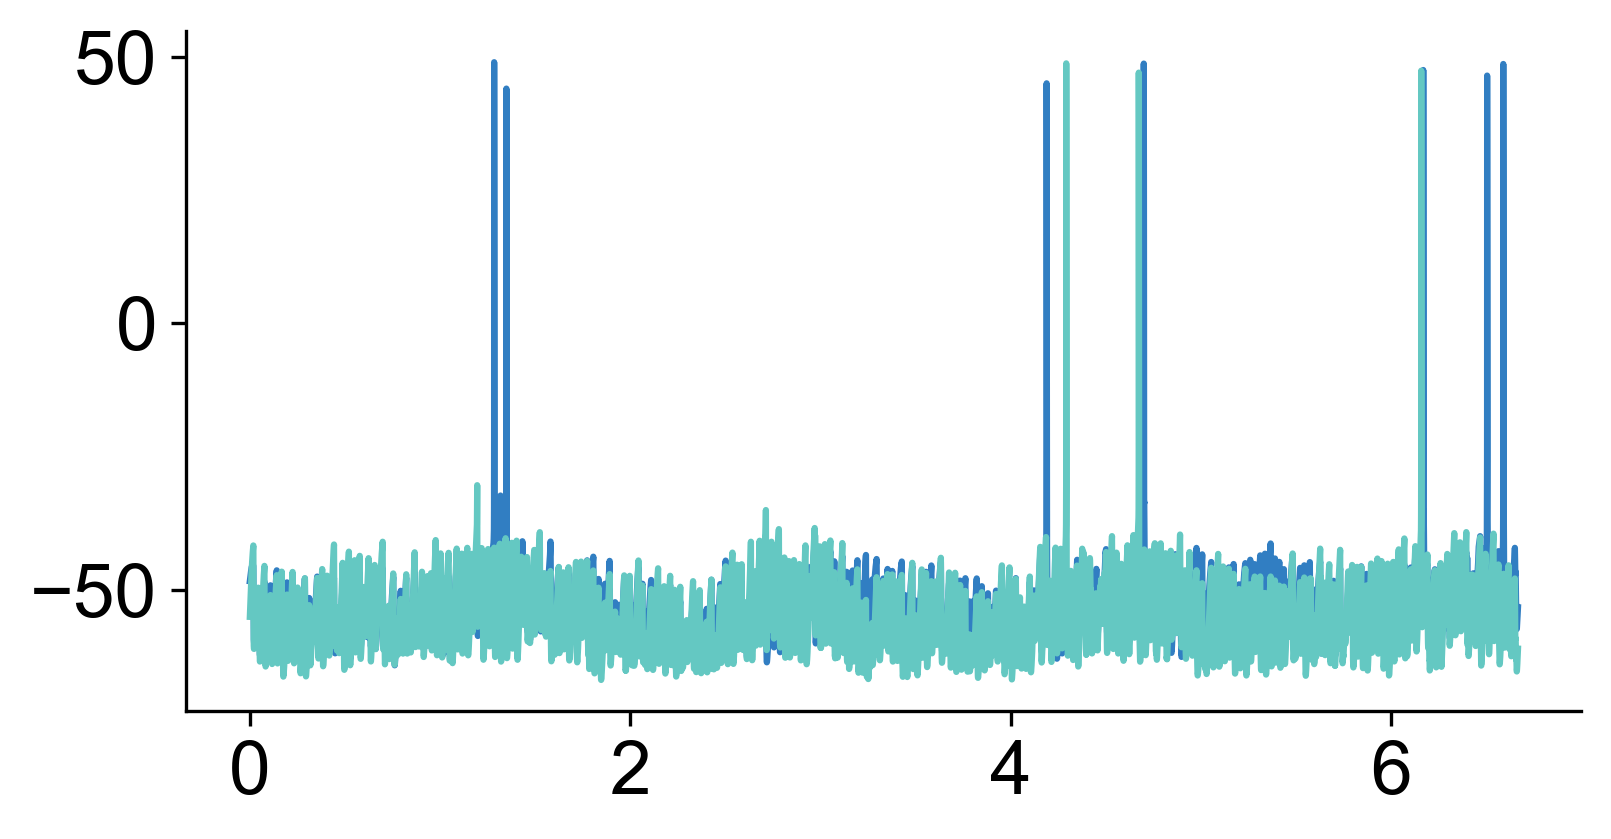

In [73]:
s = np.where(t_vec > time_for_single_lap*19+500)[0][0]
e = np.where(t_vec < time_for_single_lap*20+500)[0][-1]

# plt.figure()
# plt.plot(t_vec[s:e], list(exc_v_vecs[65])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[66])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[64])[s:e], color='k')
# plt.plot(t_vec[s:e], list(pvbc_v_vecs[0])[s:e], color='r')
# plt.show()

fig = plt.figure(figsize=(6,3), dpi=300)
ax  = fig.gca()
plt.plot( (t_vec[s:e]-t_vec[s])/1000., exc_v_vecs[250][s:e], color=(49/255., 126/255., 194/255.))
plt.plot( (t_vec[s:e]-t_vec[s])/1000., exc_v_vecs[175][s:e], color=(100/255., 200/255., 194/255.))
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show();

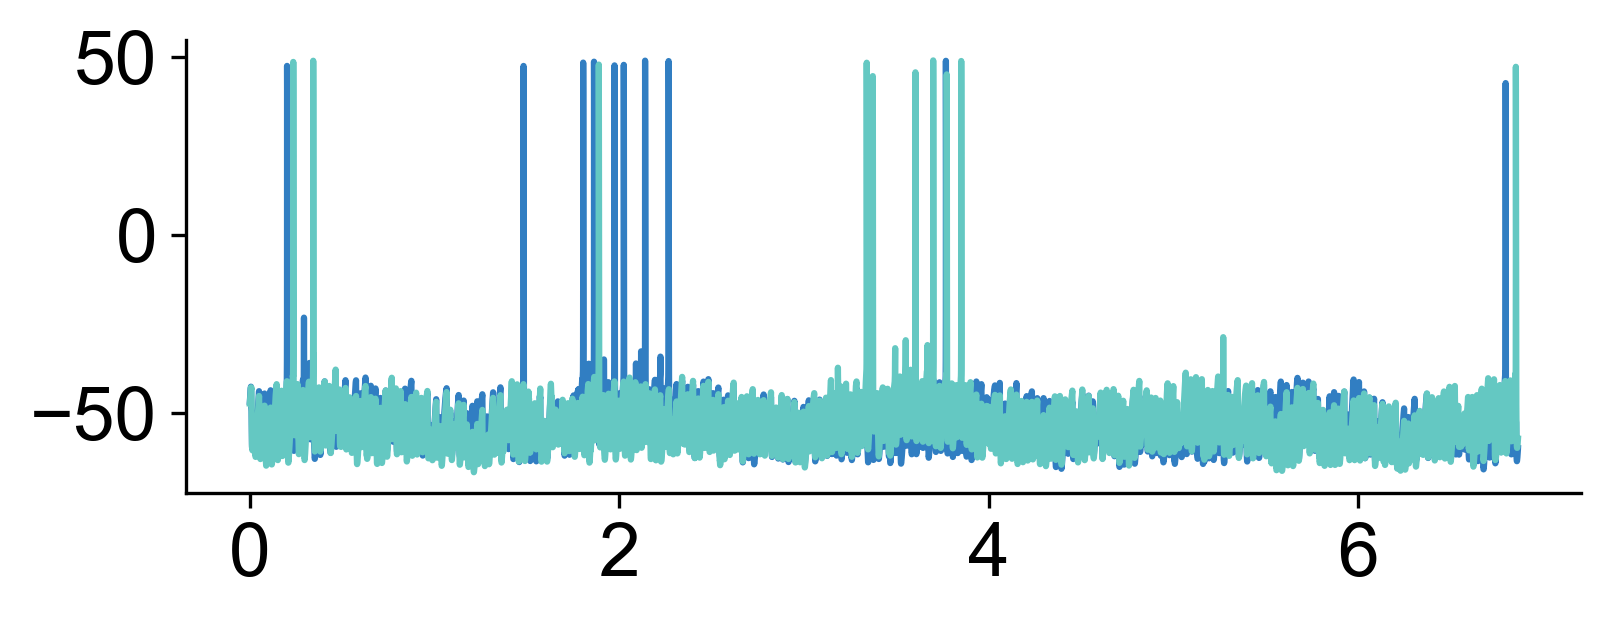

In [74]:
t_vec = np.asarray(t_vec)
s = np.where(t_vec > time_for_single_lap*9+500+1200)[0][0]
e = np.where(t_vec < time_for_single_lap*10+500+1400)[0][-1]

# plt.figure()
# plt.plot(t_vec[s:e], list(exc_v_vecs[65])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[66])[s:e], color='k')
# plt.plot(t_vec[s:e], list(exc_v_vecs[64])[s:e], color='k')
# plt.plot(t_vec[s:e], list(pvbc_v_vecs[0])[s:e], color='r')
# plt.show()

fig = plt.figure(figsize=(6,2), dpi=300)
ax  = fig.gca()
plt.plot( (t_vec[s:e]-t_vec[s])/1000., list(exc_v_vecs[130])[s:e], color=(49/255., 126/255., 194/255.))

plt.plot( (t_vec[s:e]-t_vec[s])/1000., list(exc_v_vecs[188])[s:e], color=(100/255., 200/255., 194/255.))
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show();

In [97]:
saved_weights = restore_weights(diagram, "../params/1104_grads_stdp_mf_input_lognormal-cue-ee-ei-nlaps-10-dt-zerodot1-scale-2-v1.npz")

In [76]:
len(saved_weights[0].keys())

260

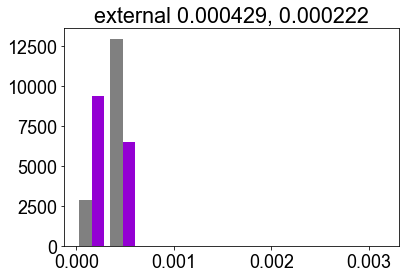

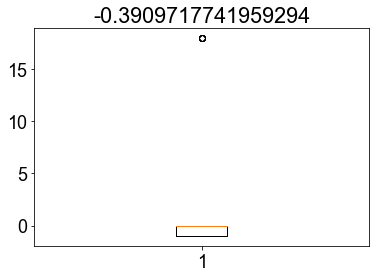

In [98]:
external_before, external_after, external_pchange = saved_weight_change(saved_weights, 100, 0)
external_pchange = np.asarray(external_pchange)

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#



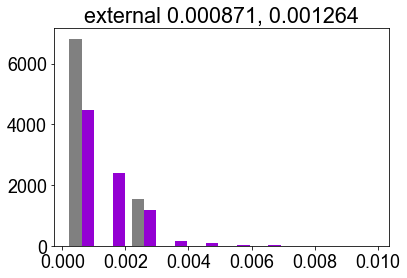

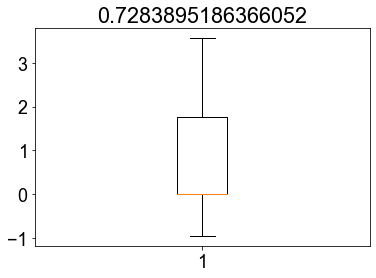

In [78]:
external_before, external_after, external_pchange = saved_weight_change(saved_weights, 102, 0)
external_pchange = np.asarray(external_pchange)

plt.figure()
plt.hist([external_before, external_after], color=['gray','darkviolet'])
plt.title('external %f, %f' % (np.mean(external_before), np.mean(external_after)))
plt.show()

plt.figure()
plt.boxplot(external_pchange)
plt.title(np.mean(external_pchange))
plt.show()

#



0.018456113


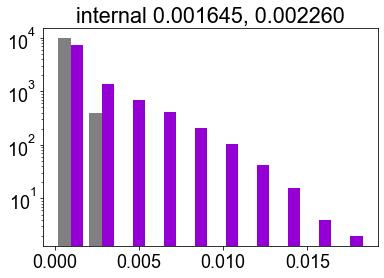

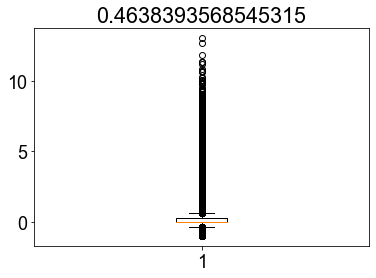

internal 0
0.73613876


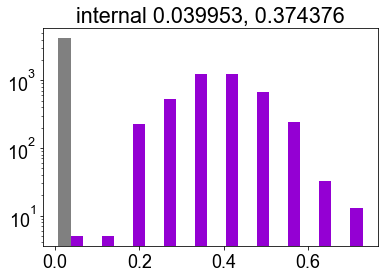

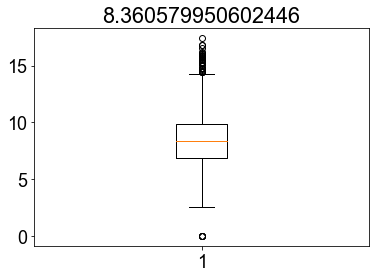

In [79]:
scale = 2

internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 0, 0)
                                                                        
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

print('internal', len(np.where(np.asarray(internal_after) >= 0.025)[0]))

#

internal_before, internal_after, internal_pchange = saved_weight_change(saved_weights, 0, 1)
internal_pchange = np.asarray(internal_pchange)
print(np.max(internal_after))


plt.figure()
plt.hist([internal_before, internal_after], color=['gray','darkviolet'])
plt.title('internal %f, %f' % (np.mean(internal_before), np.mean(internal_after)))
plt.yscale('log')
plt.show()


plt.figure()
plt.boxplot(internal_pchange)
plt.title(np.mean(internal_pchange))
plt.show()

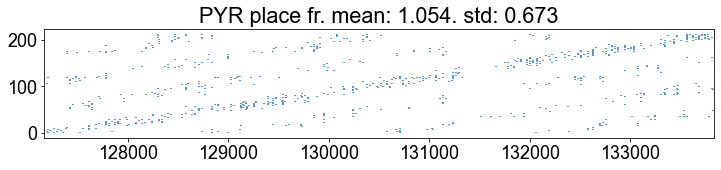

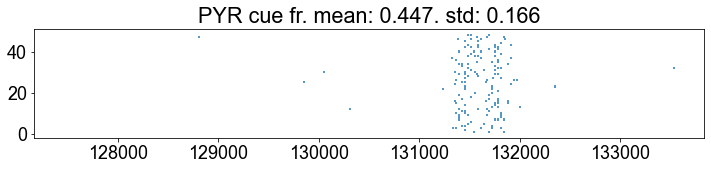

In [100]:
cell_spike_times = np.load("../data/cell_spikes_1104_grads_stdp_ei_ie_mf_mec_lec_input_lognormal-cue-ee-ei-nlaps-20.npz")

cell_spike_times = { int(gid): v for gid, v in cell_spike_times.items() }
start  = time_for_single_lap * 19. + 500
finish = time_for_single_lap * 20. + 500

plot_spikes(cell_spike_times, 'PYR place', start, finish, gids=diagram.place_information[0]['place'])
plot_spikes(cell_spike_times, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'])

#plot_spikes(circuit, 0, 'exa,ple cue', start, finish, gids=[cue_cells[4]])

#plot_spikes(circuit, 0, 'PYR all', start, finish, gids=np.arange(130*2))
#plot_spikes(circuit, 1, 'PVBC', start, finish, gids=None)

    

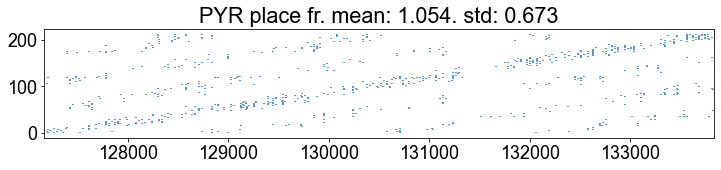

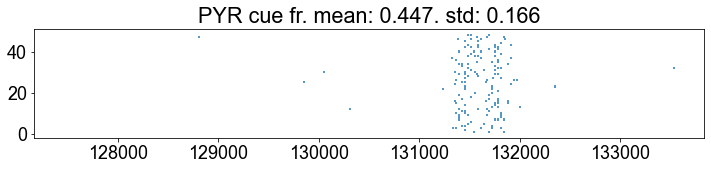

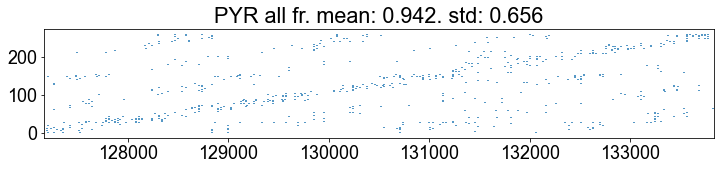

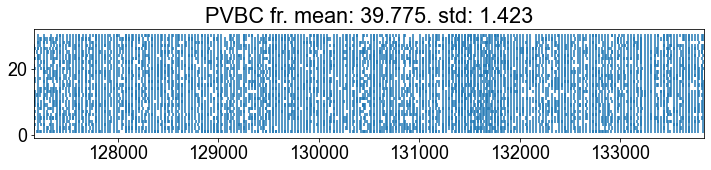

68
place-cue corr PearsonRResult(statistic=0.9998540781864529, pvalue=2.1852241424862483e-118)
place-pvbc corr PearsonRResult(statistic=0.999997176828916, pvalue=6.292473928037075e-175)
pvbc-cue corr PearsonRResult(statistic=0.9998843802158685, pvalue=1.0087748512660051e-121)


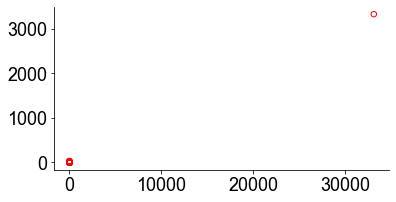

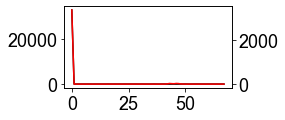

r,p -0.3047191979243398 0.011517542499017614


In [101]:


start  = time_for_single_lap * 19 + 500
finish = time_for_single_lap * 20 + 500

plot_spikes(cell_spike_times, 'PYR place', start, finish, diagram.place_information[0]['place'])
plot_spikes(cell_spike_times, 'PYR cue', start, finish, diagram.place_information[0]['not place'])
plot_spikes(cell_spike_times, 'PYR all', start, finish, np.arange(130*2))
plot_spikes(cell_spike_times, 'PVBC', start, finish, gids=np.arange(130*2, 130*2 + 30))

nspikes_place = spike_bins(cell_spike_times, start, finish, gids=diagram.place_information[0]['place'])
nspikes_cue   = spike_bins(cell_spike_times, start, finish, gids=diagram.place_information[0]['not place'])
nspikes_total = spike_bins(cell_spike_times, start, finish, gids=np.arange(130*2))
nspikes_pvbc  = spike_bins(cell_spike_times, start, finish, gids=np.arange(130*2, 130*2 + 30))


from scipy.stats import pearsonr, spearmanr
print(len(nspikes_place))
print('place-cue corr', pearsonr(nspikes_place, nspikes_cue))
print('place-pvbc corr', pearsonr(nspikes_place, nspikes_pvbc))
print('pvbc-cue corr', pearsonr(nspikes_pvbc, nspikes_cue))

#(6,3)
fig = plt.figure(figsize=(6,3))
ax  = fig.gca()
plt.scatter(nspikes_place, nspikes_cue, facecolor='none', edgecolor='red',s=30)
# plt.xlabel('number place cells spikes')
# plt.ylabel('number cue cells spikes')
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

fig, ax = plt.subplots(figsize=(3,1.5))
ax.plot(nspikes_place, color='k')
ax2 = ax.twinx()
ax2.plot(nspikes_cue, color='r')
plt.show()

from scipy.stats import pearsonr, spearmanr
r, p = spearmanr(nspikes_place, nspikes_cue)
print('r,p', r, p)

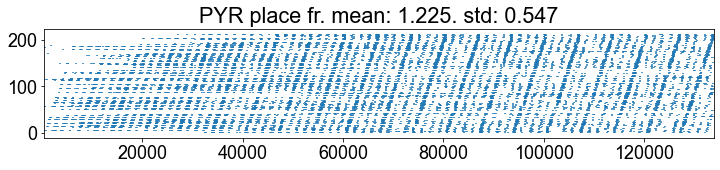

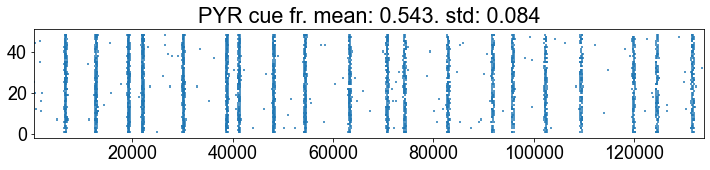

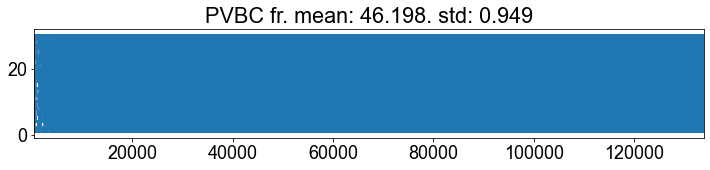

In [102]:
start  = time_for_single_lap * 0. + 500
finish = time_for_single_lap * 20. + 500

plot_spikes(cell_spike_times, 'PYR place', start, finish, gids=diagram.place_information[0]['place'])#, color=(49/255.,126/255.,194/255.))
plot_spikes(cell_spike_times, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'])#, color=(231/255.,135/255.,43/255.))
#plot_spikes(circuit, 0, 'PYR all', start, finish, gids=np.arange(130))
plot_spikes(cell_spike_times, 'PVBC', start, finish, gids=np.arange(130*2, 130*2 + 30))#, color=(224/255.,127/255., 128/255.))

#plot_spikes(circuit, 1, 'PVBC', start, finish, gids=np.arange(130,145))

# plot_spikes(circuit, 2, 'AAC', start, finish)
# plot_spikes(circuit, 3, 'BiS', start, finish)
# plot_spikes(circuit, 4, 'OLM', start, finish)
# plot_spikes(circuit, 5, 'ISCCR', start, finish)
    

5.161572339721001 4.893098176903604e-07


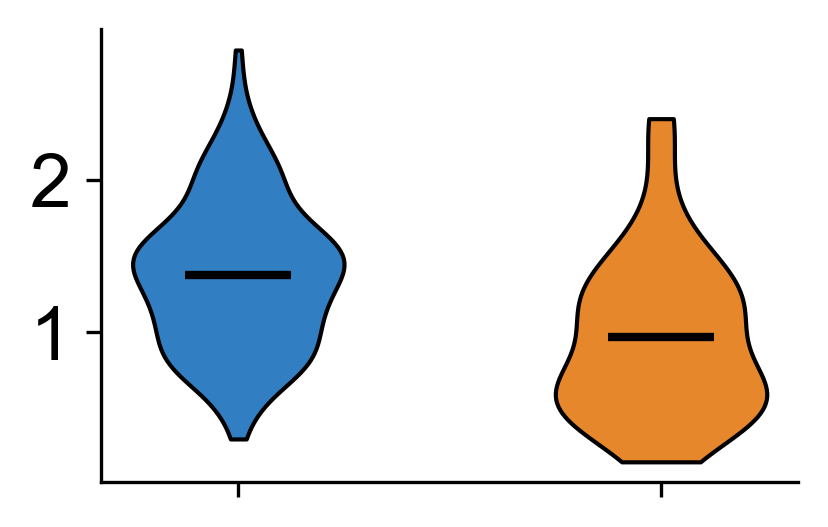

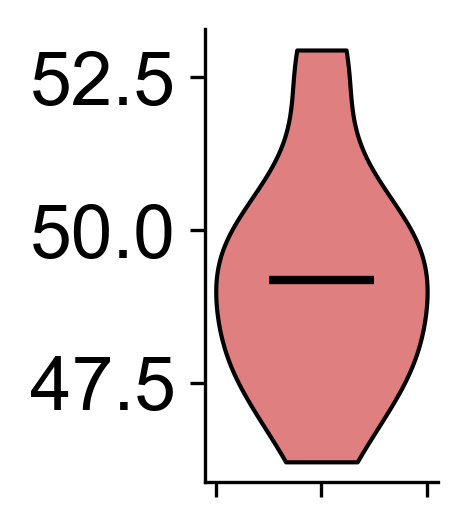

In [87]:
from scipy.stats import ttest_ind

def get_pop_frs(spike_times, title, start, finish, gids=None, color='k'):
    
    frs = []
    for (gid,sts) in spike_times.items():
        if gid not in gids:
            continue
        sts = np.divide(np.asarray(sts), 1000.)
        sts_chop = sts[np.where( (sts>=start/1000.) & (sts<=finish/1000.)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
        
    return frs

start  = time_for_single_lap * 9 + 500
finish = time_for_single_lap * 10 + 500

colors = [(49/255.,126/255.,194/255.), (231/255.,135/255.,43/255.), (224/255.,127/255., 128/255.)]

place_frs = get_pop_frs(cell_spike_times, 'PYR place', start, finish, gids=diagram.place_information[0]['place'], color=(49/255.,126/255.,194/255.))
cue_frs   = get_pop_frs(cell_spike_times, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'], color=(231/255.,135/255.,43/255.))
int_frs   = get_pop_frs(cell_spike_times, 'PVBC', start, finish, gids=np.arange(130*2,130*2 + 30))

t, p = ttest_ind(place_frs, cue_frs)
print(t,p)

fig = plt.figure(dpi=300, figsize=(3,2))
ax = fig.gca()
vplot = plt.violinplot([place_frs, cue_frs], showextrema=False, showmeans=True, positions=[0,1])
ax.set_xticklabels([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

for (i,pc) in enumerate(vplot['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)

vp = vplot['cmeans']
vp.set_edgecolor('black')
vp.set_linewidth(2)
    
plt.show()

#####
colors = [(224/255.,127/255., 128/255.)]

fig = plt.figure(dpi=300, figsize=(1,2))
ax = fig.gca()
vplot = plt.violinplot([int_frs], showextrema=False, showmeans=True, positions=[0])
ax.set_xticklabels([])
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

for (i,pc) in enumerate(vplot['bodies']):
    pc.set_facecolor(colors[i])
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)

vp = vplot['cmeans']
vp.set_edgecolor('black')
vp.set_linewidth(2)
    
plt.show()

5200
place median 0.0067223767
nonplace median 0.0033668433
place mean 0.0068312357
nonplace mean 0.0034072162
88.98995600635622 0.0
4067138.0 0.0


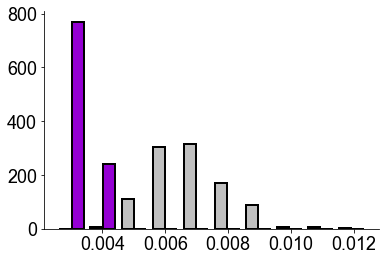

In [88]:
place_cells = diagram.place_information[0]['place']
non_place_cells = diagram.place_information[0]['not place']
scale = 2

pvbc_to_place_weights = []
for pgid in place_cells:
    cell_info = saved_weights[0][pgid]
    src_gids, connection_weights, connection_weights_upd = cell_info[1]
    pvbc_inds = np.argwhere(np.logical_and(src_gids >= 130*2, src_gids < 130*2 + 30))[:,0]
    weights = connection_weights[pvbc_inds] + connection_weights_upd[pvbc_inds]
    pvbc_to_place_weights.append(weights)

pvbc_to_place_weights = np.concatenate(pvbc_to_place_weights)            
            
pvbc_to_notplace_weights = []
for pgid in non_place_cells:
    cell_info = saved_weights[0][pgid]
    src_gids, connection_weights, connection_weights_upd = cell_info[1]
    pvbc_inds = np.argwhere(np.logical_and(src_gids >= 130*2, src_gids < 130*2 + 30))[:,0]
    
    weights = connection_weights[pvbc_inds] + connection_weights_upd[pvbc_inds]
    pvbc_to_notplace_weights.append(weights)
            
pvbc_to_notplace_weights = np.concatenate(pvbc_to_notplace_weights)            
            
print(len(pvbc_to_place_weights) + len(pvbc_to_notplace_weights))
        
fig = plt.figure()
ax  = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=['silver', 'darkviolet'], 
         density=True, edgecolor='k', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

print('place mean', np.mean(pvbc_to_place_weights))
print('nonplace mean', np.mean(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind, mannwhitneyu
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)

u, p2 = mannwhitneyu(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(u, p2)

5192
place min 0.0010941437
nonplace min 0.0013440051
place median 0.0038226075
nonplace median 0.0029881317
place mean 0.004669886
nonplace mean 0.0035809684
11.72189815252838 2.4375421146812182e-31
2512718.0 3.081968079191419e-24


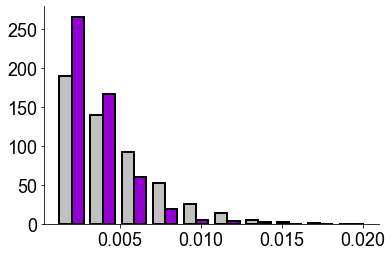

In [89]:
place_cells = diagram.place_information[0]['place']
non_place_cells = diagram.place_information[0]['not place']
scale = 2

pyr_to_place_weights = []
for pgid in place_cells:
    cell_info = saved_weights[0][pgid]
    src_gids, connection_weights, connection_weights_upd = cell_info[0]
    weights = connection_weights[~np.isnan(connection_weights_upd)] + connection_weights_upd[~np.isnan(connection_weights_upd)]
    pyr_to_place_weights.append(weights)

pyr_to_place_weights = np.concatenate(pyr_to_place_weights)            
            
pyr_to_notplace_weights = []
for pgid in non_place_cells:
    cell_info = saved_weights[0][pgid]
    src_gids, connection_weights, connection_weights_upd = cell_info[0]
    
    weights = connection_weights[~np.isnan(connection_weights_upd)] + connection_weights_upd[~np.isnan(connection_weights_upd)]
    pyr_to_notplace_weights.append(weights)
            
pyr_to_notplace_weights = np.concatenate(pyr_to_notplace_weights)            
            
print(len(pyr_to_place_weights) + len(pyr_to_notplace_weights))
        
fig = plt.figure()
ax  = fig.gca()
plt.hist([pyr_to_place_weights, pyr_to_notplace_weights], color=['silver', 'darkviolet'], 
         density=True, edgecolor='k', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place min', np.min(pyr_to_place_weights))
print('nonplace min', np.min(pyr_to_notplace_weights))

print('place median', np.median(pyr_to_place_weights))
print('nonplace median', np.median(pyr_to_notplace_weights))

print('place mean', np.mean(pyr_to_place_weights))
print('nonplace mean', np.mean(pyr_to_notplace_weights))

from scipy.stats import ttest_ind, mannwhitneyu
t, p = ttest_ind(pyr_to_place_weights, pyr_to_notplace_weights)
print(t, p)

u, p2 = mannwhitneyu(pyr_to_place_weights, pyr_to_notplace_weights)
print(u, p2)

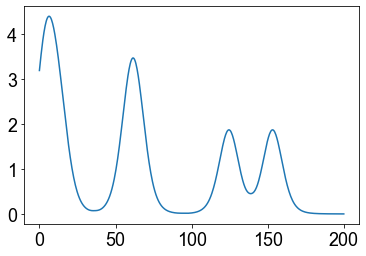

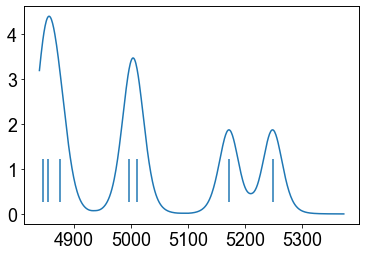

In [90]:
all_exc_frs = {}
all_exc_spikes = []
valid_gids = []
start_time = time_for_single_lap * 9 + 500
end_time   = time_for_single_lap * 10 + 500

#for i in circuit.neurons[0].keys():
for gid in place_cells:
    exc_spikes = cell_spike_times[gid]

    time_idxs = np.where( (exc_spikes >= start_time) & (exc_spikes <= end_time))[0]
    exc_spikes = exc_spikes[time_idxs]
    all_exc_spikes.append(exc_spikes)
    step = 12.5 # ms
    estimated_times = np.arange(start_time, end_time, step=step)
    if len(exc_spikes) == 0:
        all_exc_frs[gid] = np.zeros_like(estimated_times)
    else:
        estimated_fr,_ = baks(exc_spikes/1000., estimated_times/1000., a=10.0) # 1.75?
        all_exc_frs[gid] = estimated_fr
        valid_gids.append(gid)

all_exc_frs_array = np.vstack([ exc_frs for exc_frs in all_exc_frs.values() ])

idx = 167
plt.figure()
#plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs[valid_gids[idx]])
plt.plot(estimated_times/1000*30. - start_time/1000*30, all_exc_frs_array[idx])

fig, ax = plt.subplots()
ax.plot(estimated_times/step, all_exc_frs_array[idx])
ax2 = ax.twinx()
#ax2.vlines(all_exc_spikes[valid_gids[idx]]/step, 0.5, 1.5)
ax2.vlines(all_exc_spikes[idx]/step, 0.5, 1.5)

ax2.set_ylim([0, 5])
ax2.set_yticks([])
plt.show();


7.53205930082688494 3.0526629959965750501


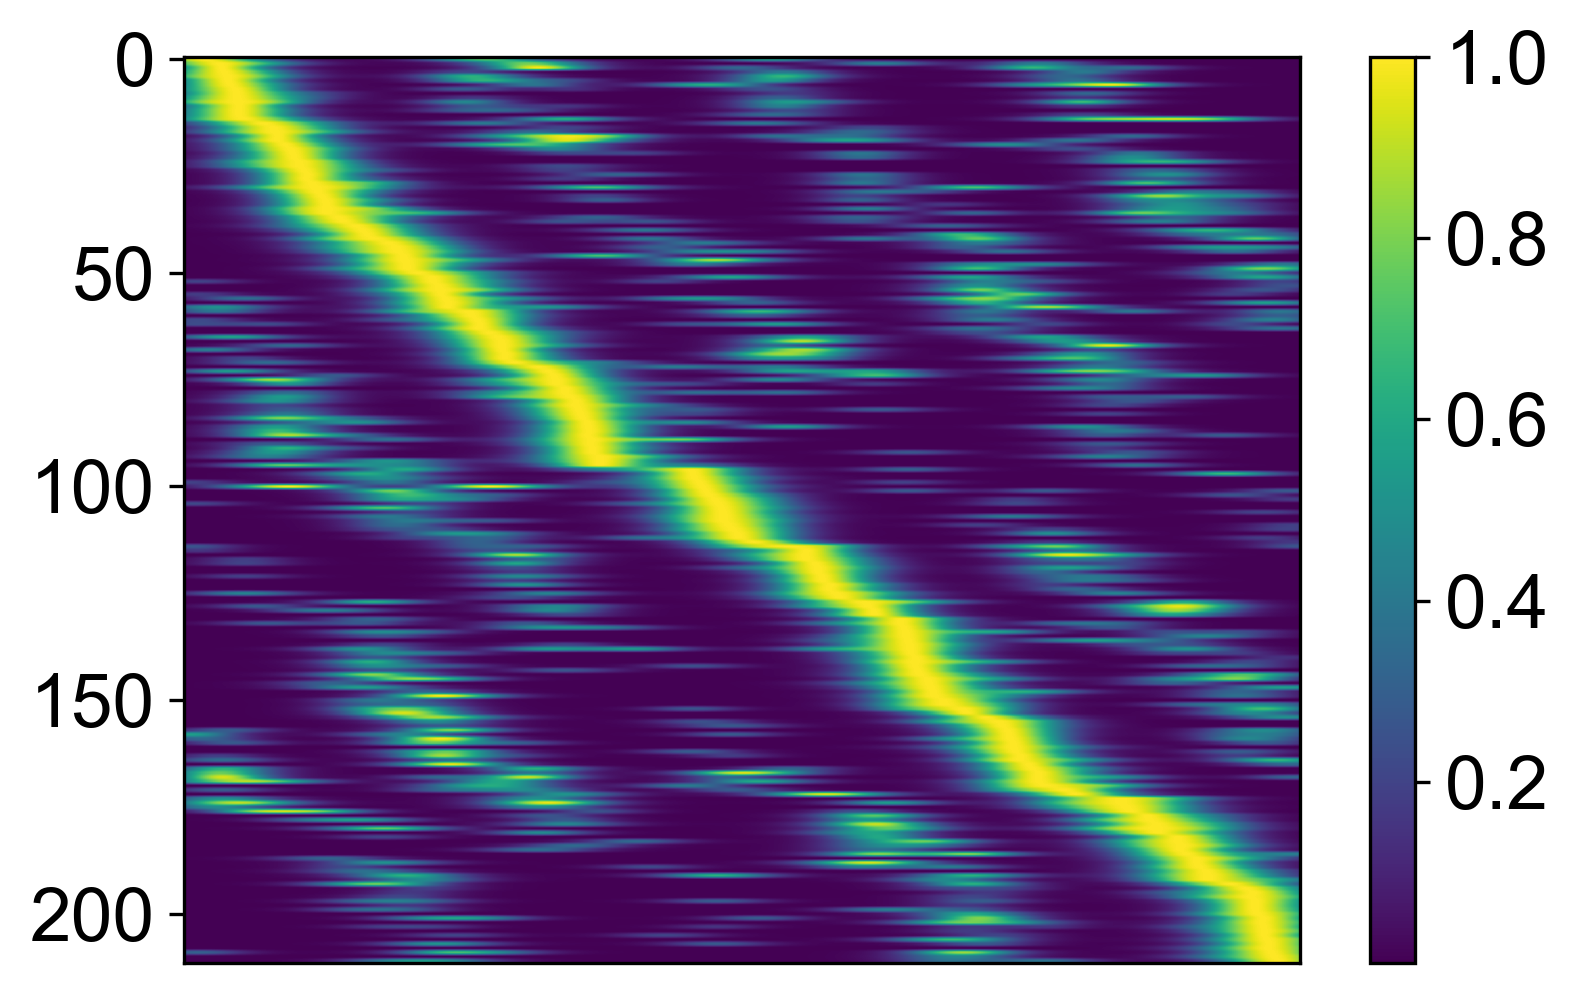

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


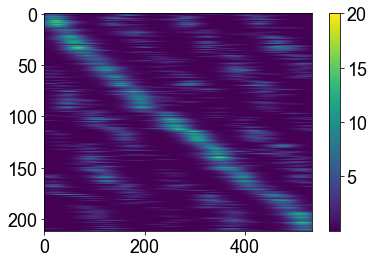

{1, 2, 3}


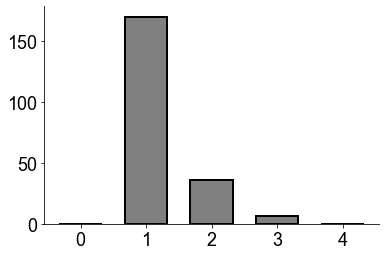

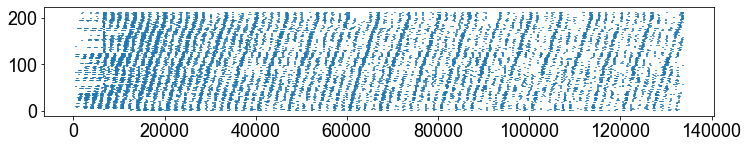

In [91]:


# valid_idxs = []
# invalid_idxs = []
# for i in range(len(all_exc_frs)):
#     sl = all_exc_frs[i]
#     if not np.all(sl < 10.0): valid_idxs.append(i)
#     else: 
#         invalid_idxs.append(i)

#valid_idxs = diagram.place_information[0]['place']#np.asarray(valid_gids)[np.asarray(valid_idxs)][sorted_max]
#valid_exc_frs = all_exc_frs[valid_idxs,:] # flip a rooni
valid_exc_frs = np.vstack([all_exc_frs[valid_gid] for valid_gid in valid_gids])
max_frs = valid_exc_frs.max(axis=1)
print(max_frs.mean(), max_frs.std())


normed = []
for i in range(len(valid_exc_frs)):
    normed.append(valid_exc_frs[i] / valid_exc_frs[i].max())
normed = np.asarray(normed, dtype='float32')

whereismax = []
for i in range(len(normed)):
    sl = normed[i,:]
    whereismax.append(sl.argmax())
sorted_max = np.argsort(whereismax)

normed_sorted        = normed[sorted_max,:]
valid_exc_frs_sorted = valid_exc_frs[sorted_max,:]


plt.figure(dpi=300)
plt.imshow(normed_sorted, cmap='viridis', aspect='auto')
plt.colorbar()
plt.xticks([])
plt.show()

plt.figure()
plt.imshow(valid_exc_frs_sorted, cmap='viridis', aspect='auto', vmax=20)
plt.colorbar()
plt.show()





# fig, ax = plt.subplots(5, 5, figsize=(12,8))
# for i in range(25):
#     xx = int(i/5)
#     yy = int(i%5)
#     ax[xx,yy].plot(estimated_times, normed_sorted[i])
#     ax[xx,yy].hlines(0.80, estimated_times[0], estimated_times[-1], linestyle='--')
#     ax[xx,yy].set_title(i)
    
ncrossed = []
for i in range(len(valid_exc_frs_sorted)):
    sl = normed_sorted[i]
    crossed = False
    ticks = 0
    for s in sl:
        if s > 0.80 and not crossed: 
            crossed = True
            ticks += 1
        if s <= 0.80 and crossed:
            crossed = False
    ncrossed.append(ticks)

ncrossed = np.asarray(ncrossed + [0 for _ in range(len(all_exc_frs) - len(valid_exc_frs))])
print(set(ncrossed))
fig = plt.figure()
ax = fig.gca()
plt.hist(ncrossed, bins=[0,1,2,3,4,5], align='left', rwidth=0.65, 
         edgecolor='k', color='gray', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
plt.show()

valid_raster = []
for nid in np.asarray(valid_gids)[sorted_max]:
    valid_raster.append(cell_spike_times[nid])

plt.figure(figsize=(12,2))
for (i,sts) in enumerate(valid_raster):
    sts = np.asarray(sts)
    plt.vlines(np.asarray(sts), i+0.5, i+1.5)
#plt.xlim([start_time, end_time])
#plt.xlim([end_time, end_time+time_for_single_lap])
plt.show()



In [180]:
# weight matrix
def create_adj_matrix(circuit, src_cells, dst_cells):
    Nsrc = len(src_cells)
    Ndst = len(dst_cells)
    adj_matrix = np.zeros((Ndst,Nsrc), dtype='float32')
    
    for (cidx, cell) in enumerate(dst_cells):
        presynaptic_inputs = circuit.neurons[0][cell].internal_netcons
        for presynaptic_gid, nc, _ in presynaptic_inputs:
            if presynaptic_gid not in src_cells: continue
            try:
                pre_loc = list(src_cells).index(presynaptic_gid)
            except:
                continue
            nc = nc[0]
            weight = nc.weight[0] + nc.weight[1]
            
            adj_matrix[cidx, pre_loc] = weight
    return adj_matrix

place_cells = diagram.place_information[0]['place']#np.asarray(valid_gids)[np.asarray(valid_idxs)][sorted_max]
cue_cells = diagram.place_information[0]['not place']
print(place_cells)
adj_matrix = create_adj_matrix(circuit, place_cells, place_cells)
valid_vals = []
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i,j] > 0.0: valid_vals.append(adj_matrix[i,j])
cutoff = np.percentile(valid_vals, 0.)
adj_matrix[adj_matrix <= cutoff] = None



plt.figure(figsize=(4,4))
plt.imshow(adj_matrix, cmap='inferno', vmin=0.000, aspect='auto', vmax=0.0250)
# plt.xlabel('presynaptic')
# plt.ylabel('postsynaptic')
#plt.colorbar()
plt.show()



[0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 56, 60, 61, 62, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 133, 135, 136, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 180, 181, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 199, 200, 201, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 221, 222, 224, 225, 227, 228, 229, 230, 231, 232, 233, 235, 236, 238, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249, 251, 252, 253, 255, 256, 257, 258, 259]


NameError: name 'circuit' is not defined

place median 0.4238419
nonplace median 0.30520195
26.28747998075189 3.9989696064332343e-141


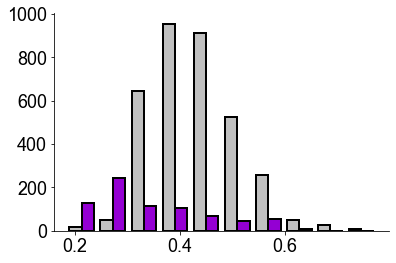

In [92]:
# motif analysis on place and non-place fields
# place_cells = place_cells
non_place_cells = diagram.place_information[0]['not place']
place_cells = diagram.place_information[0]['place']

pvbc_gids = np.arange(130*2, 130*2 + 30)
place_weights, nonplace_weights = [], []
for pvbc_gid in pvbc_gids:
    cell_info = saved_weights[1][pvbc_gid]
    src_gids, connection_weights, connection_weights_upd = cell_info[0]
    for i, src_gid in enumerate(src_gids):
        if src_gid in place_cells:
            place_weights.append(connection_weights[i] + connection_weights_upd[i])
        elif src_gid in non_place_cells:
            nonplace_weights.append(connection_weights[i] + connection_weights_upd[i])
                
fig = plt.figure()
ax  = fig.gca()
plt.hist([place_weights, nonplace_weights], color=['silver', 'darkviolet'], edgecolor='k', linewidth=2)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(place_weights))
print('nonplace median', np.median(nonplace_weights))

from scipy.stats import ttest_ind
t, p = ttest_ind(place_weights, nonplace_weights)
print(t, p)

place median 0.0067223767
nonplace median 0.0033668433
88.98995600635622 0.0


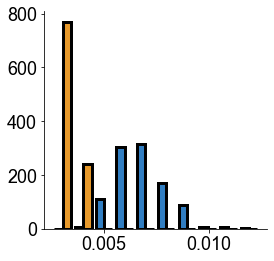

In [93]:
fig = plt.figure(figsize=(4,4))
ax  = fig.gca()
plt.hist([pvbc_to_place_weights, pvbc_to_notplace_weights], color=[(49/255.,126/255.,194/255.), (231/255.,135/225.,43/255.)], 
         density=True, edgecolor='k', linewidth=3)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
print('place median', np.median(pvbc_to_place_weights))
print('nonplace median', np.median(pvbc_to_notplace_weights))

from scipy.stats import ttest_ind
t, p = ttest_ind(pvbc_to_place_weights, pvbc_to_notplace_weights)
print(t, p)

/home/igr/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/igr/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

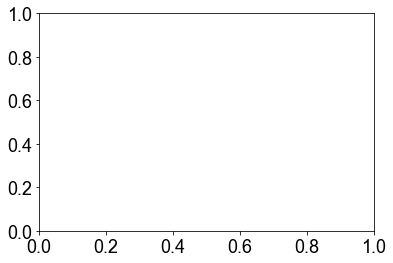

In [94]:
pvbc_gids = np.arange(130*2, 130*2 + 30)
pvbc_recurrent_weights = []
for gid in pvbc_gids:
    cell_info = saved_weights[1][gid]
    src_gids, connection_weights, connection_weights_upd = cell_info[1]
    pvbc_inds = np.argwhere(np.logical_and(src_gids >= 130*2, src_gids < 130*2 + 30))[:,0]
    weights = connection_weights[pvbc_inds] + connection_weights_upd[pvbc_inds]
    pvbc_recurrent_weights.append(weights)

pvbc_recurrent_weights = np.concatenate(pvbc_recurrent_weights)
            
plt.figure()
plt.hist([pvbc_recurrent_weights], color=['silver'], edgecolor='k', linewidth=2)
plt.show()